In [1]:
import pandas as pd
import datetime
import numpy as np
import mysql.connector
import json
import csv
import os
import matplotlib as plt
import matplotlib.pyplot as pyplot
import dataframe_image as dfi
import requests

### Downloading the most recent sales data directly from the Census Bureau website

In [2]:
# 1. define url path
url = "https://www.census.gov/retail/mrts/www/mrtssales92-present.xlsx"

# 2. download the data behind the URL
response = requests.get(url)

# 3. Open the response into a new file called mrtssales92-present.xlsx
open("mrtssales92-present.xlsx", "wb").write(response.content)

440409

### Reading the MRTS Data and Data Preparation

In [4]:
xlsx = pd.ExcelFile("mrtssales92-present.xlsx")

sheets_dict = pd.read_excel(xlsx)

sales_df = pd.DataFrame()

for sheet in reversed(xlsx.sheet_names):
    
    # Capture the 65 Adjusted business types from column B in the spreadsheet and place them into a dataframe
    categories = pd.read_excel(xlsx, sheet_name=sheet, header = 3, usecols ="B").iloc[2:67]

    # The first sheet, 2022, has 7 less columns than the others so it has an exception
    if sheet == '2022':
        sales_figs = pd.read_excel(xlsx, sheet_name=sheet, header = 4, usecols ="C:J").iloc[1:66]
    else:
        # Otherwise place the 65 rows of values from columns C through N into a dataframe
        sales_figs = pd.read_excel(xlsx, sheet_name=sheet, header = 4, usecols ="C:N").iloc[1:66]

    # Combine the dataframe containing the business types with the dataframe that holds their associated sales figures.
    reshaped_df = pd.concat([categories.reset_index(drop=True),sales_figs.reset_index(drop=True)], axis=1)
    sales_df = pd.concat([sales_df,reshaped_df.reset_index(drop=True)], axis=1)

In [5]:
sales_df.shape

(65, 399)

In [6]:
sales_df.head()

,Kind of Business,Jan. 1992,Feb. 1992,Mar. 1992,Apr. 1992,May 1992,Jun. 1992,Jul. 1992,Aug. 1992,Sep. 1992,...,Dec. 2021,Kind of Business,Jan. 2022,Feb. 2022,Mar. 2022,Apr. 2022,May 2022,Jun. 2022,Jul. 2022,Aug. 2022
0,"Retail and food services sales, total",146376,147079,159336,163669,170068,168663,169890,170364,164617,...,711673,"Retail and food services sales, total",587961,579139,681854,681357,705001,697935,690050,702729
1,Retail sales and food services excl motor vehi...,116565,115862,124200,127587,133608,130274,132076,134928,128734,...,589369,Retail sales and food services excl motor vehi...,474414,462148,541746,544061,572984,565376,562385,566838
2,Retail sales and food services excl gasoline s...,134277,135499,147064,151226,156619,155236,156016,156539,151477,...,659844,Retail sales and food services excl gasoline s...,538863,529564,617457,616581,632118,622594,615971,634752
3,Retail sales and food services excl motor vehi...,104466,104282,111928,115144,120159,116847,118202,121103,115594,...,537540,Retail sales and food services excl motor vehi...,425316,412573,477349,479285,500101,490035,488306,498861
4,"Retail sales, total",130683,131244,142488,147175,152420,151849,152586,152476,148158,...,632849,"Retail sales, total",518146,506400,597077,594426,614474,609933,600746,613416


In [7]:
sales_df = sales_df.drop(columns ='Kind of Business').rename(columns={'May 2022 (p)': 'May 2022', 'Aug. 2022(p)': 'Aug 2022'})
sales_df.head()

,Jan. 1992,Feb. 1992,Mar. 1992,Apr. 1992,May 1992,Jun. 1992,Jul. 1992,Aug. 1992,Sep. 1992,Oct. 1992,...,Nov. 2021,Dec. 2021,Jan. 2022,Feb. 2022,Mar. 2022,Apr. 2022,May 2022,Jun. 2022,Jul. 2022,Aug. 2022
0,146376,147079,159336,163669,170068,168663,169890,170364,164617,173655,...,654469,711673,587961,579139,681854,681357,705001,697935,690050,702729
1,116565,115862,124200,127587,133608,130274,132076,134928,128734,136917,...,538632,589369,474414,462148,541746,544061,572984,565376,562385,566838
2,134277,135499,147064,151226,156619,155236,156016,156539,151477,159992,...,602186,659844,538863,529564,617457,616581,632118,622594,615971,634752
3,104466,104282,111928,115144,120159,116847,118202,121103,115594,123254,...,486349,537540,425316,412573,477349,479285,500101,490035,488306,498861
4,130683,131244,142488,147175,152420,151849,152586,152476,148158,155987,...,579687,632849,518146,506400,597077,594426,614474,609933,600746,613416


In [8]:
melted_sales_df = sales_df.transpose()
melted_sales_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
Jan. 1992,146376,116565,134277,104466,130683,100872,33906,29811,26788,25800,...,658,371,6860,2692,1916,15693,1049,13325,6887,6438
Feb. 1992,147079,115862,135499,104282,131244,100027,35220,31217,28203,27031,...,798,402,6059,2285,1627,15835,1026,13474,6937,6537
Mar. 1992,159336,124200,147064,111928,142488,107352,38731,35136,31684,30195,...,714,419,6297,2484,1537,16848,1074,14346,7245,7101
Apr. 1992,163669,127587,151226,115144,147175,111093,40548,36082,32547,30583,...,801,393,6022,2506,1341,16494,1031,14065,7000,7065
May 1992,170068,133608,156619,120159,152420,115960,42213,36460,32883,31095,...,900,435,5803,2483,1163,17648,1047,15077,7532,7545


In [9]:
categories['Kind of Business'] = categories['Kind of Business'].str.replace("Retail sales and food services","RSFS",regex=True)
categories['Kind of Business'] = categories['Kind of Business'].str.replace("\(|\)|\.|,|'","",regex=True).str.replace("-| ","_",regex=True)

melted_sales_df.columns = categories['Kind of Business'].to_list()
melted_sales_df = melted_sales_df.replace(to_replace="\(S\)|\(NA\)",value=np.nan,regex=True)
melted_sales_df = melted_sales_df.where((pd.notnull(melted_sales_df)), 0)

melted_sales_df.head()

,Retail_and_food_services_sales_total,RSFS_excl_motor_vehicle_and_parts,RSFS_excl_gasoline_stations,RSFS_excl_motor_vehicle_and_parts_and_gasoline_stations,Retail_sales_total,Retail_sales_total_excl_motor_vehicle_and_parts_dealers,GAFO1,Motor_vehicle_and_parts_dealers,Automobile_and_other_motor_vehicle_dealers,Automobile_dealers,...,Gift_novelty_and_souvenir_stores,Used_merchandise_stores,Nonstore_retailers,Electronic_shopping_and_mail_order_houses,Fuel_dealers,Food_services_and_drinking_places,Drinking_places,Restaurants_and_other_eating_places,Full_service_restaurants,Limited_service_eating_places
Jan. 1992,146376.0,116565.0,134277.0,104466.0,130683.0,100872.0,33906.0,29811.0,26788.0,25800.0,...,658.0,371.0,6860.0,2692.0,1916.0,15693.0,1049.0,13325.0,6887.0,6438.0
Feb. 1992,147079.0,115862.0,135499.0,104282.0,131244.0,100027.0,35220.0,31217.0,28203.0,27031.0,...,798.0,402.0,6059.0,2285.0,1627.0,15835.0,1026.0,13474.0,6937.0,6537.0
Mar. 1992,159336.0,124200.0,147064.0,111928.0,142488.0,107352.0,38731.0,35136.0,31684.0,30195.0,...,714.0,419.0,6297.0,2484.0,1537.0,16848.0,1074.0,14346.0,7245.0,7101.0
Apr. 1992,163669.0,127587.0,151226.0,115144.0,147175.0,111093.0,40548.0,36082.0,32547.0,30583.0,...,801.0,393.0,6022.0,2506.0,1341.0,16494.0,1031.0,14065.0,7000.0,7065.0
May 1992,170068.0,133608.0,156619.0,120159.0,152420.0,115960.0,42213.0,36460.0,32883.0,31095.0,...,900.0,435.0,5803.0,2483.0,1163.0,17648.0,1047.0,15077.0,7532.0,7545.0


In [10]:
melted_sales_df.reset_index(inplace=True)
melted_sales_df.head()

,index,Retail_and_food_services_sales_total,RSFS_excl_motor_vehicle_and_parts,RSFS_excl_gasoline_stations,RSFS_excl_motor_vehicle_and_parts_and_gasoline_stations,Retail_sales_total,Retail_sales_total_excl_motor_vehicle_and_parts_dealers,GAFO1,Motor_vehicle_and_parts_dealers,Automobile_and_other_motor_vehicle_dealers,...,Gift_novelty_and_souvenir_stores,Used_merchandise_stores,Nonstore_retailers,Electronic_shopping_and_mail_order_houses,Fuel_dealers,Food_services_and_drinking_places,Drinking_places,Restaurants_and_other_eating_places,Full_service_restaurants,Limited_service_eating_places
0,Jan. 1992,146376.0,116565.0,134277.0,104466.0,130683.0,100872.0,33906.0,29811.0,26788.0,...,658.0,371.0,6860.0,2692.0,1916.0,15693.0,1049.0,13325.0,6887.0,6438.0
1,Feb. 1992,147079.0,115862.0,135499.0,104282.0,131244.0,100027.0,35220.0,31217.0,28203.0,...,798.0,402.0,6059.0,2285.0,1627.0,15835.0,1026.0,13474.0,6937.0,6537.0
2,Mar. 1992,159336.0,124200.0,147064.0,111928.0,142488.0,107352.0,38731.0,35136.0,31684.0,...,714.0,419.0,6297.0,2484.0,1537.0,16848.0,1074.0,14346.0,7245.0,7101.0
3,Apr. 1992,163669.0,127587.0,151226.0,115144.0,147175.0,111093.0,40548.0,36082.0,32547.0,...,801.0,393.0,6022.0,2506.0,1341.0,16494.0,1031.0,14065.0,7000.0,7065.0
4,May 1992,170068.0,133608.0,156619.0,120159.0,152420.0,115960.0,42213.0,36460.0,32883.0,...,900.0,435.0,5803.0,2483.0,1163.0,17648.0,1047.0,15077.0,7532.0,7545.0


In [11]:
melted_sales_df['index']=pd.to_datetime(melted_sales_df['index'])
melted_sales_df.head()

,index,Retail_and_food_services_sales_total,RSFS_excl_motor_vehicle_and_parts,RSFS_excl_gasoline_stations,RSFS_excl_motor_vehicle_and_parts_and_gasoline_stations,Retail_sales_total,Retail_sales_total_excl_motor_vehicle_and_parts_dealers,GAFO1,Motor_vehicle_and_parts_dealers,Automobile_and_other_motor_vehicle_dealers,...,Gift_novelty_and_souvenir_stores,Used_merchandise_stores,Nonstore_retailers,Electronic_shopping_and_mail_order_houses,Fuel_dealers,Food_services_and_drinking_places,Drinking_places,Restaurants_and_other_eating_places,Full_service_restaurants,Limited_service_eating_places
0,1992-01-01,146376.0,116565.0,134277.0,104466.0,130683.0,100872.0,33906.0,29811.0,26788.0,...,658.0,371.0,6860.0,2692.0,1916.0,15693.0,1049.0,13325.0,6887.0,6438.0
1,1992-02-01,147079.0,115862.0,135499.0,104282.0,131244.0,100027.0,35220.0,31217.0,28203.0,...,798.0,402.0,6059.0,2285.0,1627.0,15835.0,1026.0,13474.0,6937.0,6537.0
2,1992-03-01,159336.0,124200.0,147064.0,111928.0,142488.0,107352.0,38731.0,35136.0,31684.0,...,714.0,419.0,6297.0,2484.0,1537.0,16848.0,1074.0,14346.0,7245.0,7101.0
3,1992-04-01,163669.0,127587.0,151226.0,115144.0,147175.0,111093.0,40548.0,36082.0,32547.0,...,801.0,393.0,6022.0,2506.0,1341.0,16494.0,1031.0,14065.0,7000.0,7065.0
4,1992-05-01,170068.0,133608.0,156619.0,120159.0,152420.0,115960.0,42213.0,36460.0,32883.0,...,900.0,435.0,5803.0,2483.0,1163.0,17648.0,1047.0,15077.0,7532.0,7545.0


In [12]:
melted_sales_df.rename(columns={'index':'Month'}, inplace=True)
melted_sales_df.head()

,Month,Retail_and_food_services_sales_total,RSFS_excl_motor_vehicle_and_parts,RSFS_excl_gasoline_stations,RSFS_excl_motor_vehicle_and_parts_and_gasoline_stations,Retail_sales_total,Retail_sales_total_excl_motor_vehicle_and_parts_dealers,GAFO1,Motor_vehicle_and_parts_dealers,Automobile_and_other_motor_vehicle_dealers,...,Gift_novelty_and_souvenir_stores,Used_merchandise_stores,Nonstore_retailers,Electronic_shopping_and_mail_order_houses,Fuel_dealers,Food_services_and_drinking_places,Drinking_places,Restaurants_and_other_eating_places,Full_service_restaurants,Limited_service_eating_places
0,1992-01-01,146376.0,116565.0,134277.0,104466.0,130683.0,100872.0,33906.0,29811.0,26788.0,...,658.0,371.0,6860.0,2692.0,1916.0,15693.0,1049.0,13325.0,6887.0,6438.0
1,1992-02-01,147079.0,115862.0,135499.0,104282.0,131244.0,100027.0,35220.0,31217.0,28203.0,...,798.0,402.0,6059.0,2285.0,1627.0,15835.0,1026.0,13474.0,6937.0,6537.0
2,1992-03-01,159336.0,124200.0,147064.0,111928.0,142488.0,107352.0,38731.0,35136.0,31684.0,...,714.0,419.0,6297.0,2484.0,1537.0,16848.0,1074.0,14346.0,7245.0,7101.0
3,1992-04-01,163669.0,127587.0,151226.0,115144.0,147175.0,111093.0,40548.0,36082.0,32547.0,...,801.0,393.0,6022.0,2506.0,1341.0,16494.0,1031.0,14065.0,7000.0,7065.0
4,1992-05-01,170068.0,133608.0,156619.0,120159.0,152420.0,115960.0,42213.0,36460.0,32883.0,...,900.0,435.0,5803.0,2483.0,1163.0,17648.0,1047.0,15077.0,7532.0,7545.0


### Writing an Installation Script

In [12]:
config = {
    'user': os.environ.get("MYSQL_DB_USER"),
    'password': os.environ.get("MYSQL_DB_PW"),
    'host': os.environ.get("MYSQL_DB_HOST"),
    'database': os.environ.get("MYSQL_DB_NAME")
}

cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()

In [13]:
col_count = [len(l.split(",")) for l in melted_sales_df.columns]

# Creating database table based on column names and count
# Month column is of different data type and needs to be accomodated for
SQL_SALES_TBL = "DROP TABLE IF EXISTS Sales; CREATE TABLE Sales("

SQL_SALES_TBL += "Month DATE, "

for name in range(1, len(col_count)):
    SQL_SALES_TBL += "{} DECIMAL(13,2), ".format(melted_sales_df.columns[name])
SQL_SALES_TBL = SQL_SALES_TBL.rstrip(" ,")
SQL_SALES_TBL += ");"

In [14]:
cursor.execute(SQL_SALES_TBL)

cursor.close()
cnx.close()

In [15]:
# Define function using cursor.executemany() to insert the dataframe
def execute_many(conn, datafrm, table):
    
    # Creating a list of tuples from the dataframe values
    tpls = [tuple(x) for x in datafrm.to_numpy()]
    
    # Comma-separated columns
    cols = ','.join(list(datafrm.columns))

    # placeholders = ','.join(['%s'] * len(datafrm.columns))
    
    # SQL query to execute
    sql = """INSERT INTO %s(%s) VALUES(%%s,%%s,%%s,%%s,%%s,%%s,%%s,
    %%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,
    %%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,
    %%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,
    %%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s,%%s)""" % (table, cols)
    
    # sql = f"INSERT INTO {table} ({cols}) VALUES ({placeholders})"

    cursor = conn.cursor()
    try:
        cursor.executemany(sql, tpls)
        conn.commit()
        print("Data inserted using execute_many() successfully...")
    except mysql.connector.Error as err:
        print("Error while inserting to MySQL", err)

In [16]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()

In [17]:
execute_many(cnx, melted_sales_df, "Sales")

Data inserted using execute_many() successfully...


### Running Queries From Python

In [ ]:
monthly_retail_actuals = pd.read_sql("""SELECT Month,
                                               Retail_and_food_services_sales_total  
                                        FROM Sales 
                                        WHERE Month >= '2017-01-01'""", con=cnx)

comparisons = pd.read_sql("""SELECT Month, 
                                    Book_stores, 
                                    Sporting_goods_stores, 
                                    Hobby_toy_and_game_stores 
                             FROM Sales 
                             WHERE Month >= '2017-01-01'""", con=cnx)

cursor.close()
cnx.close()

In [19]:
monthly_retail_actuals.head()

,Month,Retail_and_food_services_sales_total
0,2017-01-01,422032.0
1,2017-02-01,418388.0
2,2017-03-01,483153.0
3,2017-04-01,465824.0
4,2017-05-01,494645.0


### Exploring Trends

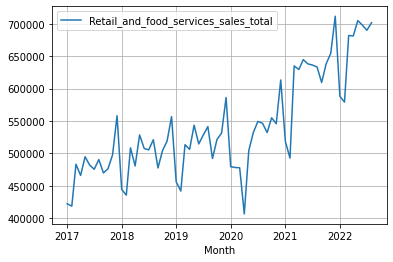

In [20]:
monthly_retail_actuals.plot(x='Month', y='Retail_and_food_services_sales_total', kind='line', grid=1)
plt.pyplot.show()

Total sales for the retail and food services categories are volatile within each month but trending upward year over year.

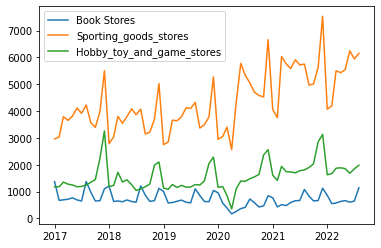

In [21]:
pyplot.plot(comparisons['Month'], comparisons['Book_stores'], label = 'Book Stores')
pyplot.plot(comparisons['Month'], comparisons['Sporting_goods_stores'],label = 'Sporting_goods_stores')
pyplot.plot(comparisons['Month'], comparisons['Hobby_toy_and_game_stores'],label = 'Hobby_toy_and_game_stores')
pyplot.legend()
pyplot.show()

Within this group, Sporting goods stores have the highest growth rate in sales.

### Exploring Percentage Change

In [22]:
comparisons = comparisons.set_index('Month')

percent_changes = comparisons.pct_change()

pd.options.display.float_format = '{:.1%}'.format

# Heatmap
heatmap_changes = percent_changes.style.background_gradient(cmap ='coolwarm')

dfi.export(heatmap_changes, "table.png")

![](table.png)

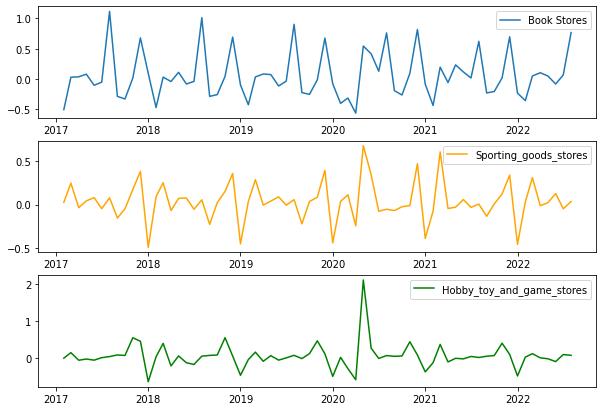

In [24]:
from turtle import color

pyplot.subplot(3, 1, 1)
pyplot.plot(percent_changes.index, percent_changes['Book_stores'], label = 'Book Stores')
pyplot.legend()

pyplot.subplot(3, 1, 2)
pyplot.plot(percent_changes.index, percent_changes['Sporting_goods_stores'], label = 'Sporting_goods_stores', color = "orange")
pyplot.legend()

pyplot.subplot(3, 1, 3)
pyplot.plot(percent_changes.index, percent_changes['Hobby_toy_and_game_stores'], label = 'Hobby_toy_and_game_stores', color = "green")
pyplot.legend()

pyplot.rcParams["figure.figsize"] = (10,7)
pyplot.show()

Seasons are more noticeable when visualizing change rates over a span of years. Here we see Sporting goods stores peaking during the fourth quarter of each year and then diving at the beginning of each year.

## Reference

US Census Bureau: Monthly Retail Trade. https://www.census.gov/retail/index.html.